In [ ]:
import re 

def conv(x): # 1-200 scale to 20-80
    if type(x) is str:
        x = int(x)
    r = x*60.0/200+20 # 0 -> 20, 200 -> 80
    return int(round(r/5)*5)

In [41]:
from datautil.gamelog import simplify_game_logs

def analysis(fn, rating_map):
    evntMap = {}
    for res in simplify_game_logs(fn):
        try:
            pitcher_info = rating_map[res['pitcher']]
            batter_info = rating_map[res['batter']]
        except:
            # fix: dump csv after season is done
            continue

        pitcher_hand = 'r' if pitcher_info['throws'] == 1 else 'l'

        match batter_info['bats']: #switch
            case 1:
                batter_hand = 'l'
            case 2:
                batter_hand = 'r'
            case 3: #switch
                batter_hand = 'l' if pitcher_hand == 'r' else 'r'

        key = (conv(pitcher_info['pitching_ratings_vs' + batter_hand + '_movement']), conv(batter_info['batting_ratings_vs' + pitcher_hand + '_power']))
        evnt,ab = evntMap.get(key, (0,0))
        evnt += 1 if res['result'] == "HR" else 0
        ab += 1 if res['is_ab'] else 0
        evntMap[key] = (evnt,ab)

    return [[evntMap.get((p,b),(0,0)) for b in range(20,85,5)] for p in range(20,85,5)]
            

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Example 2D list

def show_heat_map(data_raw):
    # Convert the 2D list to a numpy array
    data = [[t[0]/t[1]*100 if t[1]>50 else 0 for t in row] for row in data_raw]
    data_array = np.array(data)

    # Create the plot
    plt.imshow(data_array, cmap='Blues', vmin=0, vmax=15)
    plt.colorbar()

    plt.xlabel('Batter Power')
    plt.ylabel('Pitcher Mov')
    plt.title('HR/AB')

    # Add labels and title
    ratings = list(range(20,85,5))
    plt.xticks(np.arange(len(ratings)), ratings)
    plt.yticks(np.arange(len(ratings)), ratings)

    for i in range(len(ratings)):
        for j in range(len(ratings)):
            if data[i][j] > 0:
                plt.text(j, i, "{:.1f}%\n{}".format(data[i][j],data_raw[i][j][1]), ha='center', va='center', color='black', fontsize=6)

    # Display the plot
    plt.gca().invert_yaxis()
    plt.show()

In [43]:
from datautil.gamelog import load_logs
from datautil.stat_loader import load_player_rating_map

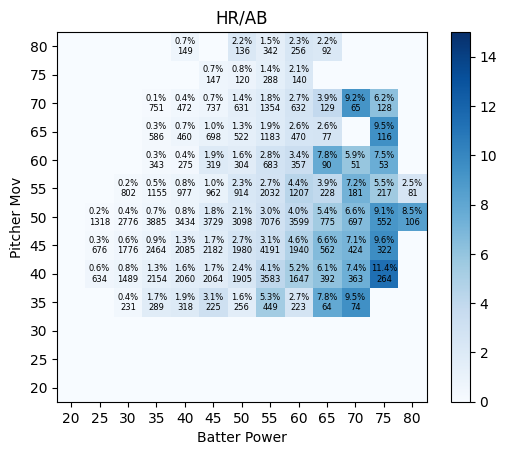

In [44]:
data1 = analysis(load_logs('test_1000'), load_player_rating_map('test_1000'))
show_heat_map(data1)

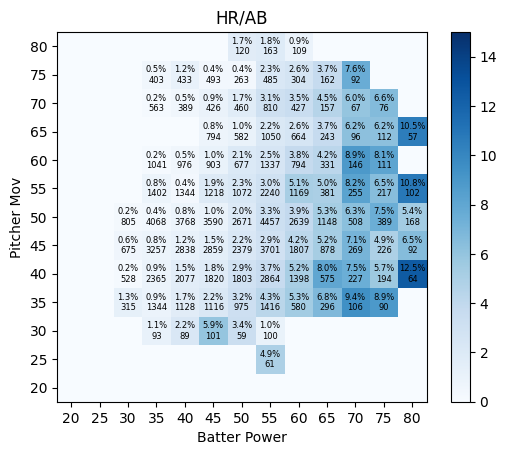

In [45]:
data2 = analysis(load_logs('test_1001'), load_player_rating_map('test_1001'))
show_heat_map(data2)

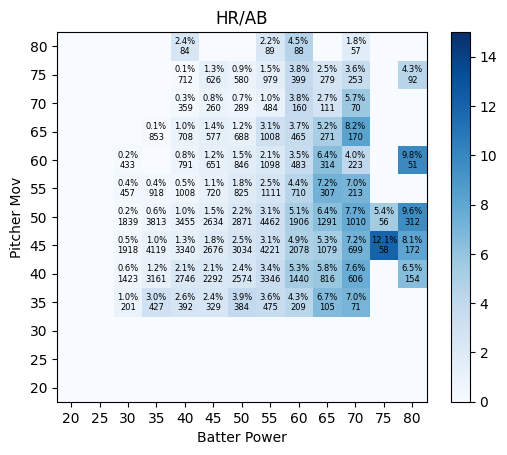

In [46]:
data3 = analysis(load_logs('test_1002'), load_player_rating_map('test_1002'))
show_heat_map(data3)

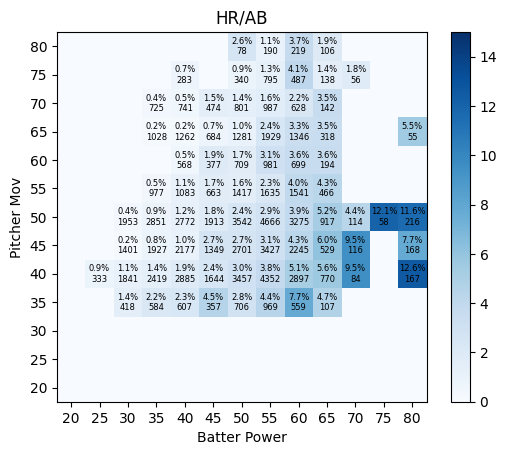

In [47]:
data4 = analysis(load_logs('test_1003'), load_player_rating_map('test_1003'))
show_heat_map(data4)

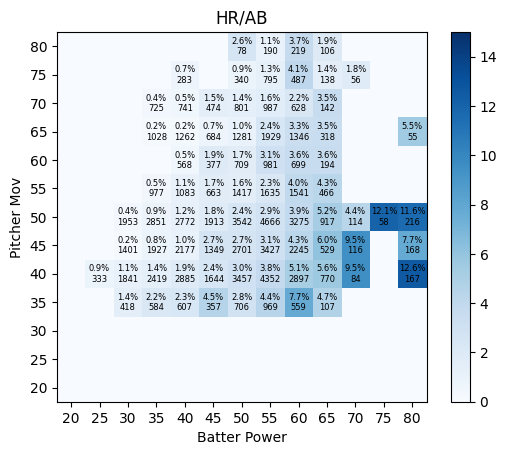

In [48]:
data5 = analysis(load_logs('test_1004'), load_player_rating_map('test_1004'))
show_heat_map(data4)

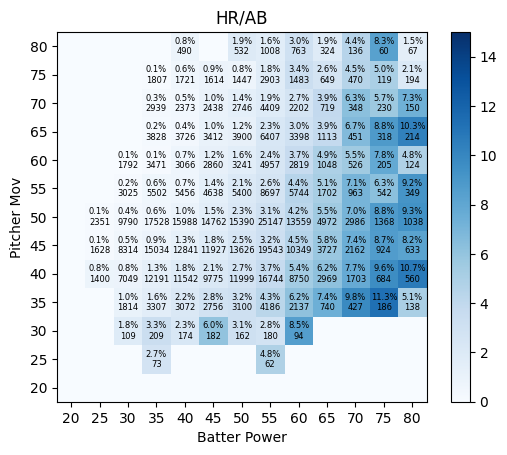

In [49]:
data = []
targets = [data1, data2, data3, data4, data5]
for i in range(len(data1)):
    r = []
    for j in range(len(data1[0])):
        a = sum([t[i][j][0] for t in targets])
        b = sum([t[i][j][1] for t in targets])
        r.append((a,b))
    data.append(r)

show_heat_map(data)